# İkinci el araba fiyatları tahmini

Bu not defterinde, ikinci el arabalar ve fiyatları hakkındaki [Kaggle](https://www.kaggle.com/avikasliwal/used-cars-price-prediction) veri kümesiyle çalışacağım. Defter ilk önce veri setinin araştırılmasını ve ardından fiyatların tahmin edilmesini içerir.

## Import libraries

Yılı işlemek için "datetime"ı, dizilerle çalışmak için "numpy"yi ve veri kümesi dosyalarını okumak için "pandas"ı, çizim için "matplotlib" ve "seaborn"u ve çeşitli makine öğrenimi modelleri için "sklearn"i içe aktaracağım.

In [1]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

## Read dataset

Veri setini okuyup onun hakkında bilgi alacağız.

In [2]:
dataset = pd.read_csv("/kaggle/input/dataset/dataset.csv")
dataset.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Analiz

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


**1)Veri setinde toplam kaç satır veri vardır?**

In [4]:
dataset.shape

(6019, 14)

**2) Veri setinde bulunan araçlar hangi yıllara aittir?**

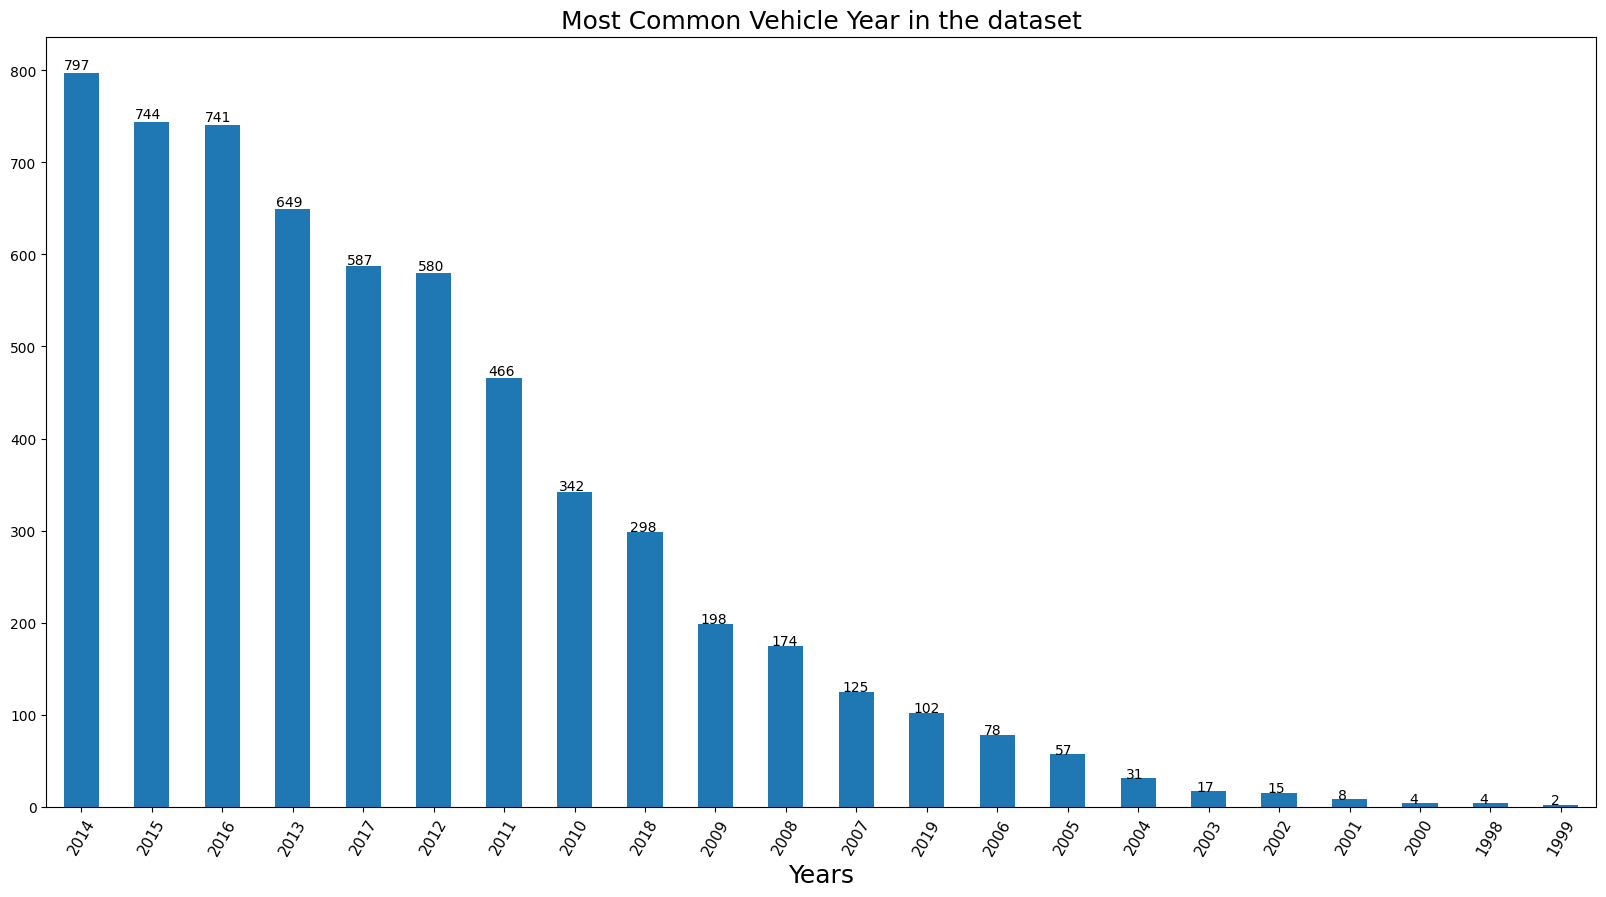

In [5]:
ax = pd.value_counts(dataset['Year']).plot.bar(figsize=(20,10))
ax.set_title("Most Common Vehicle Year in the dataset", fontsize=18)
ax.set_xlabel("Years", fontsize=18);
ax.set_xticklabels(pd.value_counts(dataset['Year']).index,rotation=60, fontsize=11)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
#Verileri sıralayarak daha okunabilir hale gertirdik

**3) Aynı üretim yılına sahip olan araçlar, en çok hangi yıla aittir?**

In [6]:
df=dataset
df['Year'].value_counts().idxmax()

2014

**4) Araçlarda kullanılan yakıt tipleri nelerdir?**

In [7]:
print(df['Fuel_Type'].unique())

['CNG' 'Diesel' 'Petrol' 'LPG' 'Electric']


**5) Araçlarda kullanılan yakıt tiplerinin dagılımı nasıldır?**

In [8]:
dagılım = df['Fuel_Type'].value_counts()
print(dagılım)

Fuel_Type
Diesel      3205
Petrol      2746
CNG           56
LPG           10
Electric       2
Name: count, dtype: int64


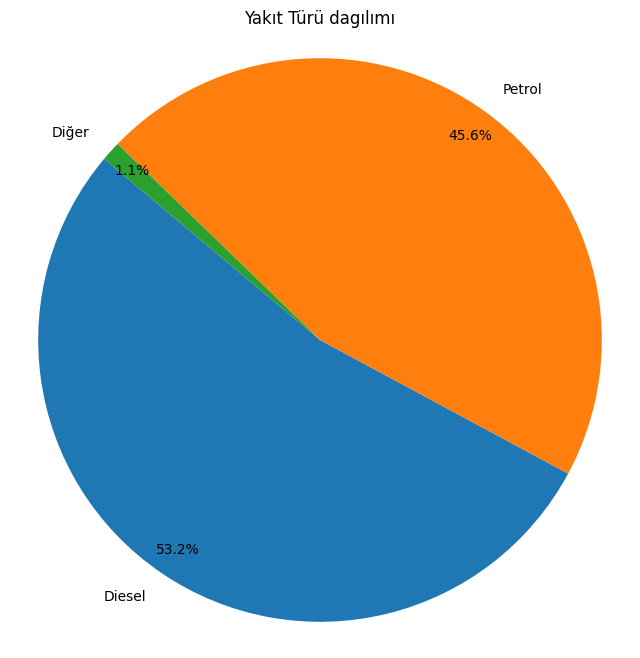

In [9]:
# %5'ten küçük olan değerleri "Diğer" kategorisi altında birleştirmek istiyorum
threshold = 0.05

dagılım = dagılım[dagılım >= threshold * len(df)]
dagılım['Diğer'] = len(df) - dagılım.sum()

plt.figure(figsize=(8, 8))  # Grafiğin boyutunu 
plt.pie(dagılım, labels=dagılım.index, autopct='%1.1f%%', startangle=140,pctdistance=0.90)
plt.title('Yakıt Türü dagılımı')
plt.axis('equal')  # Daireyi tam bir daire olarak ayarlar
plt.show()

**4) Benzinli araçlar dahamı ucuzdur?**

In [10]:
fig = px.box(df, x='Fuel_Type',y='Price', color='Transmission', notched=True)
fig.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.05,xanchor="right",x=1))
fig.show()

> Bu da Benzinli aracın Dizelden daha ucuz olduğunu doğruladı.

**6) Yakıtı Diesel olan arçların yıllara göre dagılımı nedir?**

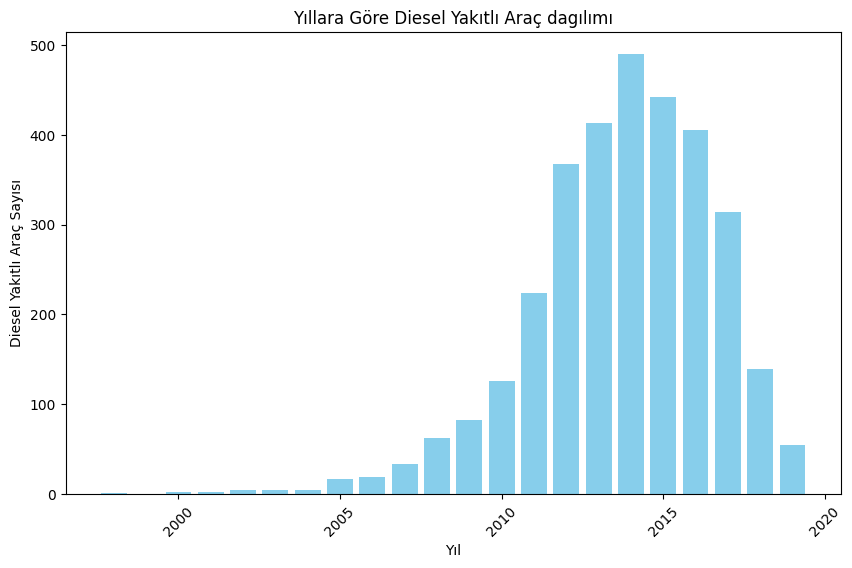

In [11]:
diesel_arac_df = df[df['Fuel_Type'] == 'Diesel']
yillara_gore_diesel = diesel_arac_df['Year'].value_counts().sort_index()
#Artık plot çizdirebiliriz
plt.figure(figsize=(10, 6))  # Grafik boyutunu 
plt.bar(yillara_gore_diesel.index, yillara_gore_diesel.values, color='skyblue')
plt.xlabel('Yıl')
plt.ylabel('Diesel Yakıtlı Araç Sayısı')
plt.title('Yıllara Göre Diesel Yakıtlı Araç dagılımı')
plt.xticks(rotation=45)  # x ekseni etiketlerini döndürme
plt.show()

2013-2016 yılları arasında pick yapmıştır. 2017 yılından sonra düşüşe geçmiştir.

**7) Yıllara göre Yakıt türü dağılımı nasıl değişmiştir?**

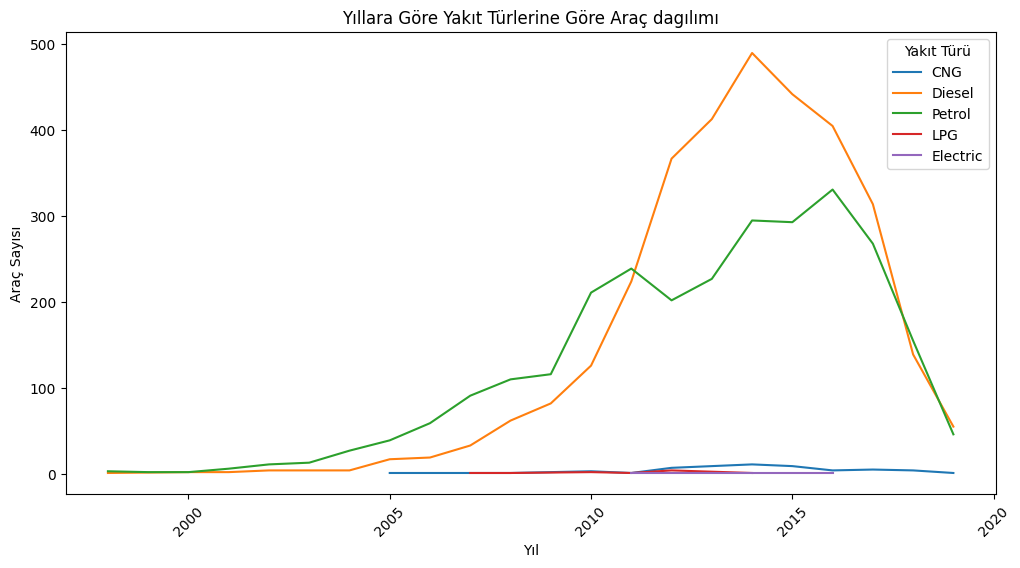

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Yakıt türlerini al
yakit_turleri = df['Fuel_Type'].unique()

# Grafik boyutunu ayarla
plt.figure(figsize=(12, 6))

# Her bir yakıt türü için çizgi grafik oluştur
for yakit_turu in yakit_turleri:
    # Veriyi filtrele
    filtered_data = df[df['Fuel_Type'] == yakit_turu]
    
    # Yıllara göre grupla ve say
    yillara_gore_sayi = filtered_data['Year'].value_counts().sort_index()
    
    # Çizgi grafik oluştur
    sns.lineplot(x=yillara_gore_sayi.index, y=yillara_gore_sayi.values, label=yakit_turu)

# Eksen etiketleri ve başlık
plt.xlabel('Yıl')
plt.ylabel('Araç Sayısı')
plt.title('Yıllara Göre Yakıt Türlerine Göre Araç dagılımı')

# Legend ekle (yakıt türüne göre renkler)
plt.legend(title='Yakıt Türü')

# x eksenini döndür
plt.xticks(rotation=45)

# Grafiği göster
plt.show()

**8) En çok tercih edilen vites türü Otomatik vites midir?**

In [13]:
vites_dagılımı = df['Transmission'].value_counts()
print(vites_dagılımı)

Transmission
Manual       4299
Automatic    1720
Name: count, dtype: int64


Hayır. Manuel vites türü daha çok tercih edilmiştir.

**9) Neden Manuel Vites ?**

Otomatik vitesli araçların , manuel vitesli araçlara göre daha az yakıt tüketimi yaptığı bir çok kaynak tarafından bilinmektedir. Ayrııca daha konforludur. Peki insanların bu sebeplere rağmen neden en çok manuel vites tercih etmiştir sorusunun cevabı olarak fiyat avantajı olduğunu düşünüyorum. Bunu araştıralım

In [14]:
manuel_vites_fiyatlar = df[df['Transmission'] == 'Manual']['Price']
otomatik_vites_fiyatlar = df[df['Transmission'] == 'Automatic']['Price']

ortalama_manuel_vites_fiyat = manuel_vites_fiyatlar.mean()
ortalama_otomatik_vites_fiyat = otomatik_vites_fiyatlar.mean()

print("Manuel Vitesli Araçların Ortalama Fiyatı:", ortalama_manuel_vites_fiyat)
print("Otomatik Vitesli Araçların Ortalama Fiyatı:", ortalama_otomatik_vites_fiyat)

Manuel Vitesli Araçların Ortalama Fiyatı: 5.33270295417539
Otomatik Vitesli Araçların Ortalama Fiyatı: 19.843970930232558


> Evet haklıymışız. Otomatik vitesli araçlar manuel vites araçlara oranla daha yüksek fiyata sahipler.

# Şuana kadar ki sorularımıza cevap bulabildik, verimiz temizdi. 
**Lakin bundan sonraki sorular için öncelikle veri temizleme işlemlerini yapmamız gerkmektedir.**

In [15]:
df.dtypes

Unnamed: 0             int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

Öncelikle veri kümesini eğitim ve test veri kümelerine bölelim.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], 
                                                    dataset.iloc[:, -1], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4213 entries, 4201 to 860
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4213 non-null   int64  
 1   Name               4213 non-null   object 
 2   Location           4213 non-null   object 
 3   Year               4213 non-null   int64  
 4   Kilometers_Driven  4213 non-null   int64  
 5   Fuel_Type          4213 non-null   object 
 6   Transmission       4213 non-null   object 
 7   Owner_Type         4213 non-null   object 
 8   Mileage            4212 non-null   object 
 9   Engine             4189 non-null   object 
 10  Power              4189 non-null   object 
 11  Seats              4185 non-null   float64
 12  New_Price          580 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 460.8+ KB


## Exploratory Data Analysis

Çeşitli sütunları inceleyelim ve her sütunun ne kadar yararlı olduğu hakkında bilgi verelim. Ayrıca test verilerini eğitim verilerine göre değiştireceğim.

### Index
İlk sütun her veri noktasının indeksidir ve dolayısıyla onu kolaylıkla kaldırabiliriz.

In [18]:
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

### Name

Veri kümesindeki çeşitli arabaları inceleyelim.

In [19]:
X_train["Name"].value_counts()

Name
Mahindra XUV500 W8 2WD                35
Maruti Swift VDI                      31
Maruti Ritz VDi                       26
Hyundai i10 Sportz                    25
Maruti Swift Dzire VDI                24
                                      ..
Skoda Laura L and K AT                 1
Honda Amaze S Diesel                   1
Nissan Micra XE                        1
Renault KWID Climber 1.0 MT            1
Ford Endeavour 2.2 Titanium AT 4X2     1
Name: count, Length: 1592, dtype: int64

Göründüğü gibi, veri setinde bazılarının sayısı 1'den yüksek olan birkaç araba var.
Bazen bir arabanın yeniden satış değeri aynı zamanda arabanın üreticisine de bağlıdır ve bu nedenle üreticiyi bu sütundan çıkarıp veri kümesine ekleyeceğim.

In [20]:
make_train = X_train["Name"].str.split(" ", expand = True)
make_test = X_test["Name"].str.split(" ", expand = True)

Name kolonunu incelediğimizde marka+model şeklinde yazıldığını fark ediyoeuz. Bunu ayırabiliriz.

In [21]:
X_train["Manufacturer"] = make_train[0]
X_test["Manufacturer"] = make_test[0]

Artık elimizde marka stunu da var.
Ayrıca boş değer olmadığını doğrulayalım ve tüm benzersiz değerleri tanımlayalım.

**10)En çok hangi marka araç vardır?**

Text(0, 0.5, 'Araç Sayısı')

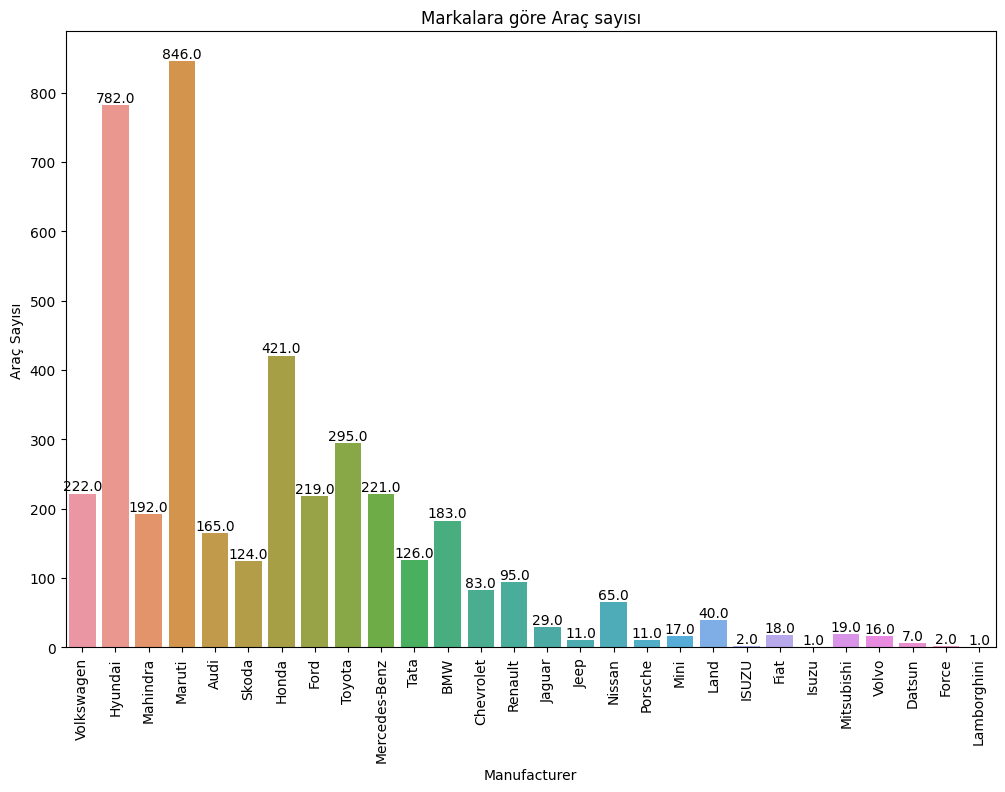

In [22]:
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = X_train)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Markalara göre Araç sayısı")
plt.xlabel("Manufacturer")
plt.ylabel("Araç Sayısı")

Veri kümesindeki maksimum arabalar üretici **Maruti**'ye aittir ve boş değer yoktur.

Ayrıca 'Name' sütununu da kaldırıcam

In [23]:
X_train.drop("Name", axis = 1, inplace = True)
X_test.drop("Name", axis = 1, inplace = True)

### Location

Bir arabanın fiyatı için konum belirleyici olmamalı ve onu güvenle kaldıracağım.

In [24]:
X_train.drop("Location", axis = 1, inplace = True)
X_test.drop("Location", axis = 1, inplace = True)

### Year

Bir arabanın kaç yaşında olduğunu bundan çıkarmaya çalışmadığımız ve yeniden satış fiyatının nasıl etkilenebileceğini görmediğimiz sürece yılın tek başına bir önemi yoktur. Bu yüzden araçların kaç yaşında olduğunu bulmamız gerekiyor.

In [25]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x : curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x : curr_time.year - x)

### Fuel_Type, Transmission,  and Owner_Type

Bu sütunların tümü, kullanılmadan önce sayılar değişkenlere dönüştürülmesi gereken kategorik sütunlardır. İlerleyen süreçte bunu yapıcaz.

### Kilometers_Driven

`Kilometers_Driven` belirli bir değer aralığına sahip sayısal bir sütundur.

In [26]:
X_train["Kilometers_Driven"]

4201     77000
4383     19947
1779     70963
4020    115195
3248     58752
         ...  
3772     27000
5191      9000
5226    140000
5390     76414
860      98000
Name: Kilometers_Driven, Length: 4213, dtype: int64


Veri aralığı çok çeşitlidir ve yüksek değerler tahmini etkileyebilir, bu nedenle ölçeklendirmenin bu sütuna mutlaka uygulanması gerçekten önemlidir.

## Kilometre

Bu sütun arabanın kilometresini tanımlar. Her dizeden sayısal değeri çıkarmamız ve kaydetmemiz gerekiyor.

In [27]:
mileage_train = X_train["Mileage"].str.split(" ", expand = True)
mileage_test = X_test["Mileage"].str.split(" ", expand = True)

X_train["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
X_test["Mileage"] = pd.to_numeric(mileage_test[0], errors = 'coerce')

Eksik değerleri kontrol edelim.

In [28]:
print("Train de bulunan boş veri",sum(X_train["Mileage"].isnull()))
print("Test de  bulunan boş veri",sum(X_test["Mileage"].isnull()))

Train de bulunan boş veri 1
Test de  bulunan boş veri 1


Her birinde birer eksik değer var. Eksik değeri, eğitim verilerine dayalı olarak sütunun ortalama değeriyle değiştireceğim.

In [29]:
X_train["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)
X_test["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)

### Engine, Power and Seats

`Engine` değerleri CC'de tanımlıdır, bu nedenle `CC`yi verilerden kaldırmam gerekiyor. Benzer şekilde, `Power`da bhp var, bu yüzden ondan `bhp`yi çıkaracağım. Ayrıca `Engine`, `Power`ve `Seats` da eksik değerler olduğundan, bunları yine ortalamayla değiştireceğim.

In [30]:
cc_train = X_train["Engine"].str.split(" ", expand = True)
cc_test = X_test["Engine"].str.split(" ", expand = True)
X_train["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')
X_test["Engine"] = pd.to_numeric(cc_test[0], errors = 'coerce')

bhp_train = X_train["Power"].str.split(" ", expand = True)
bhp_test = X_test["Power"].str.split(" ", expand = True)
X_train["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')
X_test["Power"] = pd.to_numeric(bhp_test[0], errors = 'coerce')

In [31]:
X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
X_test["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)

X_train["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)
X_test["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)

X_train["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)
X_test["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)

### Yeni fiyat

Değerlerin çoğu eksik (Nan) olduğundan bu sütunu tamamen Kaldıracağım.

In [32]:
X_train.drop(["New_Price"], axis = 1, inplace = True)
X_test.drop(["New_Price"], axis = 1, inplace = True)

## Veri işleme

Artık eğitim verileriyle çalıştığımıza göre, eğitime başlamadan önce kategorik sütunlar için yapay sütunlar oluşturalım.

In [33]:
X_train = pd.get_dummies(X_train,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)
# pd.get_dummies() işlevi, belirtilen sütunlardaki kategorik değerleri One-Hot Encoding'e dönüştürür. (Sayısal değere)
#drop-first ise trueyaptık böylece ilk sınıfın sütunu çıkarılır, sınıf sayısı kadar yeni sütun eklenir 
#ve bu sütunlar hangi sınıfın mevcut olduğunu gösterir.ilk sınıfın sütunu çıkarılır, 
#böylece sınıf sayısı kadar yeni sütun eklenir ve bu sütunlar hangi sınıfın mevcut olduğunu gösterir.

In [34]:
X_test = pd.get_dummies(X_test,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

Sahte sütun oluşturma işleminin test ve eğitim verilerinde farklı olması mümkün olabilir, bu nedenle tüm eksik sütunları sıfırlarla doldururum.

In [35]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

Son olarak veri işlemenin son adımı olarak verileri ölçeklendireceğim.

In [36]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

## Eğitim ve tahmin

Veriler üzerinde eğitmek ve bunu gelecekteki tahminlerde kullanmak için bir **Linear Regression** modeli , **GradientBoostingRegressor** ve bir **Random Forest** modeli oluşturacağım.

In [37]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
print("R2 Score for Linear Regression: ",r2_score(y_test, y_pred))

R2 Score for Linear Regression:  0.7008908549416728


In [38]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("R2 Score for Random Forest: ",r2_score(y_test, y_pred))

R2 Score for Random Forest:  0.8814813796309441


In [39]:


# Modeli oluştur
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Veriyi model ile eğit
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)
print("R2 Score for GradientBoostingRegressor: ",r2_score(y_test, y_pred))

R2 Score for GradientBoostingRegressor:  0.8730879333460471


**Random Forest** modeli, **0,88** R2 puanıyla en iyi performansı gösterdi.
Uygulanan veri madenciliği yöntemlerinin iyileştirilerek, 
R2 puanıyla en iyi performansı gösteren **Random Forest** Algoritması ile çalışmaya devam edilebileceği kanaatine varılmıştır. 
**Author:Nurullah ÇALKA**
